In [2]:
#NOT MY CODE!!! ALL CREDIT GOES TO https://humaticlabs.com/blog/compressed-sensing-python/

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
from scipy.fftpack import dct, idct, fft, ifft
from sklearn.linear_model import Lasso
from pylbfgs import owlqn
import imageio.v2 as imageio
import scipy.ndimage as spimg
import scipy.fftpack as spfft

In [3]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

Iteration 1:
  fx = 402070300.259797, xnorm = 1559.806497, gnorm = 40255.325204, step = 0.000025, k = 1, ls = 1

Iteration 2:
  fx = 185274467.989288, xnorm = 11174.594887, gnorm = 18220.187929, step = 1.000000, k = 2, ls = 1

Iteration 3:
  fx = 94807477.423437, xnorm = 24053.342705, gnorm = 2792.282500, step = 1.000000, k = 3, ls = 1

Iteration 4:
  fx = 91579867.822151, xnorm = 24272.439094, gnorm = 2266.477618, step = 1.000000, k = 4, ls = 1

Iteration 5:
  fx = 88240147.331982, xnorm = 29782.377999, gnorm = 6465.603509, step = 0.125000, k = 5, ls = 4

Iteration 6:
  fx = 78787889.506521, xnorm = 25300.281078, gnorm = 1531.158447, step = 0.125000, k = 6, ls = 4

Iteration 7:
  fx = 77040463.675621, xnorm = 28017.372159, gnorm = 3193.743448, step = 0.250000, k = 7, ls = 3

Iteration 8:
  fx = 76590603.238588, xnorm = 25163.123475, gnorm = 1830.215069, step = 0.250000, k = 8, ls = 3

Iteration 9:
  fx = 74482703.841589, xnorm = 27962.563557, gnorm = 2437.083403, step = 0.125000, k = 

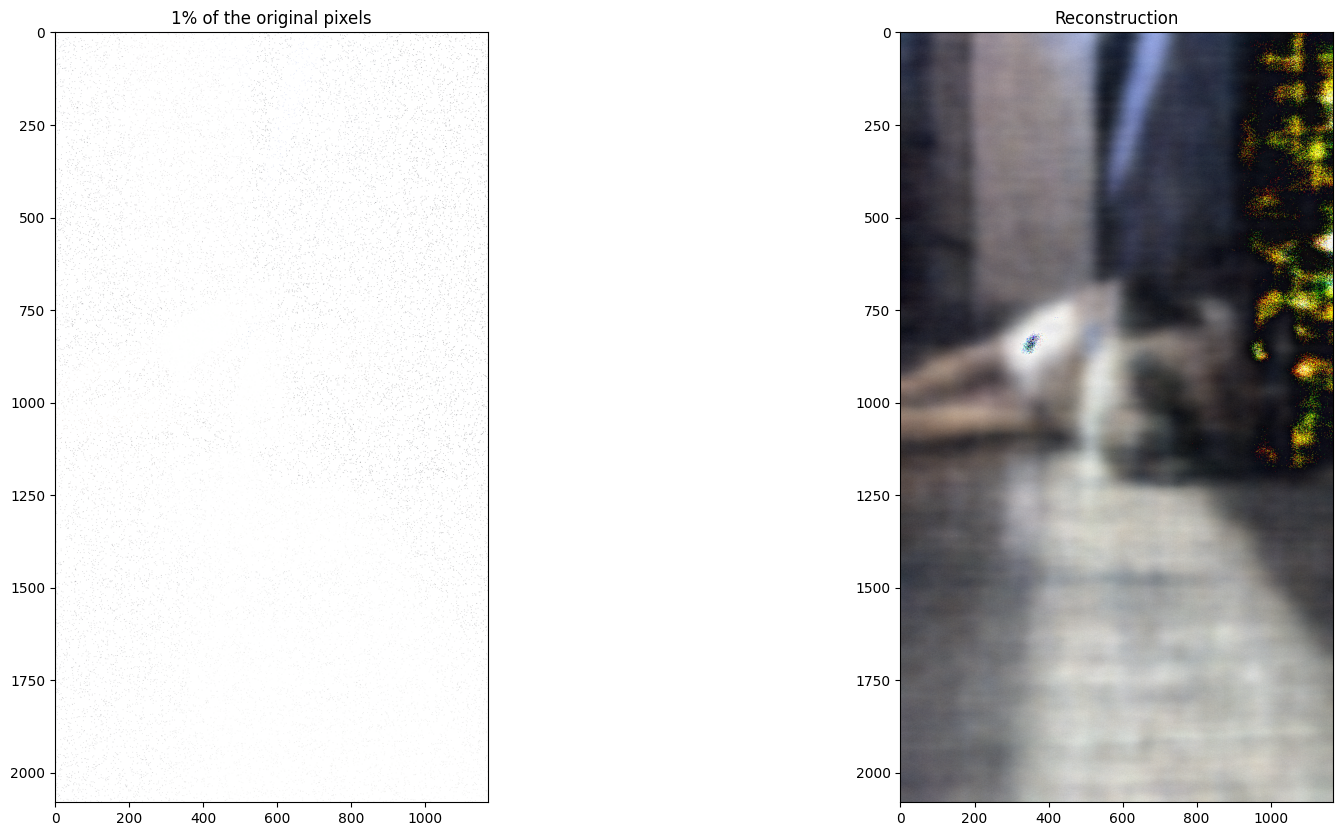

In [4]:
def evaluate(x, g, step):
    """An in-memory evaluation callback."""

    # we want to return two things: 
    # (1) the norm squared of the residuals, sum((Ax-b).^2), and
    # (2) the gradient 2*A'(Ax-b)

    # expand x columns-first
    x2 = x.reshape((nx, ny)).T

    # Ax is just the inverse 2D dct of x2
    Ax2 = idct2(x2)

    # stack columns and extract samples
    Ax = Ax2.T.flat[ri].reshape(b.shape)

    # calculate the residual Ax-b and its 2-norm squared
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # project residual vector (k x 1) onto blank image (ny x nx)
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb # fill columns-first

    # A'(Ax-b) is just the 2D dct of Axb2
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape) # stack columns

    # copy over the gradient vector
    np.copyto(g, AtAxb)

    return fx

# fractions of the scaled image to randomly sample at
sample_sizes = [0.01]

# read original image
Xorig = imageio.imread('dog1.jpg')
ny,nx,nchan = Xorig.shape
temp = np.copy(Xorig)
temp2 = np.full_like(Xorig, 255)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax = axes.ravel()

# for each sample size
Z = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
masks = [np.zeros(Xorig.shape, dtype='uint8') for s in sample_sizes]
for i,s in enumerate(sample_sizes):

    # create random sampling index vector
    k = round(nx * ny * s)
    ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
    for j in range(3):
        a = temp2[ : , : ,j].reshape(-1,1)

        a[ri] = temp[ :, :, j].reshape(-1,1)[ri]
        a = a.reshape(temp[ :, :, j].shape)
        temp2[ : , : ,j] = a

    ax[0].imshow(temp2)
    ax[0].set_title(r'1% of the original pixels')
    
    # for each color channel
    for j in range(nchan):
        
        # extract channel
        X = Xorig[:,:,j].squeeze()
        
        # create images of mask (for visualization)
        Xm = 255 * np.ones(X.shape)
        Xm.T.flat[ri] = X.T.flat[ri]
        masks[i][:,:,j] = Xm
        
        # take random samples of image, store them in a vector b
        b = X.T.flat[ri].astype(float)
        
        # perform the L1 minimization in memory
        Xat2 = owlqn(nx*ny, evaluate, None, 5)

        # transform the output back into the spatial domain
        Xat = Xat2.reshape(nx, ny).T # stack columns
        Xa = idct2(Xat)
        Z[i][:,:,j] = Xa.astype('uint8')

    ax[1].imshow(Z[0])
    ax[1].set_title('Reconstruction')